Поработать с датасетом болезней соевых бобов по адресу http://archive.ics.uci.edu/ml/datasets/Soybean+%28Large%29
1. построить три модели ML, целевой скор f1 >= 0.8 или AUC ROC >= 0.8,
2. визуализировать графики обучения,
3. отобразить истину и предсказания на тесте в 2 и 3 мерных пространствах.

В работе должны быть выводы и желательно навигация.

Сдавать либо Гитхаб либо Google Colab.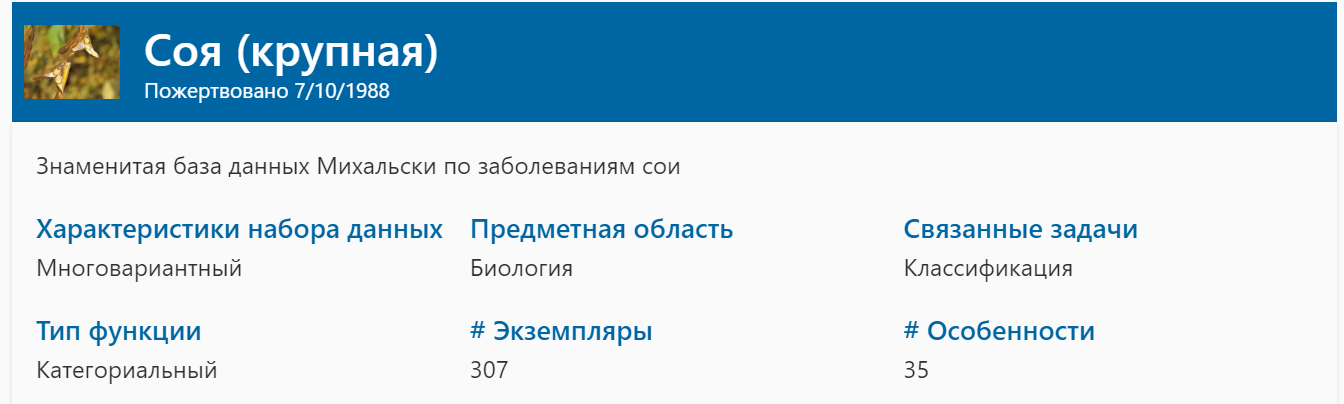

# Загрузка данных и библиотек

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
soybean_large = fetch_ucirepo(id=90)

# data (as pandas dataframes)
X = soybean_large.data.features
y = soybean_large.data.targets

# metadata
print(soybean_large.metadata)

# variable information
print(soybean_large.variables)

{'uci_id': 90, 'name': 'Soybean (Large)', 'repository_url': 'https://archive.ics.uci.edu/dataset/90/soybean+large', 'data_url': 'https://archive.ics.uci.edu/static/public/90/data.csv', 'abstract': "Michalski's famous soybean disease database", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 307, 'num_features': 35, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1980, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5JG6Z', 'creators': ['R.S. Michalski', 'R.L. Chilausky'], 'intro_paper': None, 'additional_info': {'summary': 'There are 19 classes, only the first 15 of which have been used in prior work. The folklore seems to be that the last four classes are unjustified by the data since they have so few examples. There are 35 categorical attributes, some nominal and some ordered.  The

Информация о наборе данных

Существует 19 классов, только первые 15 из которых использовались в предыдущей работе. Похоже, что данные последних четырех классов неоправданны, поскольку в них так мало примеров. Существует 35 категориальных атрибутов, некоторые номинальные, а некоторые упорядоченные. Значение "dna" означает, что оно неприменимо. Значения атрибутов кодируются численно, причем первое значение кодируется как "0", второе как "1" и т.д. Неизвестное значение кодируется как "?".

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install umap_learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.manifold import TSNE
import seaborn as sns
import plotly.express as px
from mlxtend.plotting import plot_decision_regions
from umap import UMAP


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.concat([X, y], axis=1)

In [ ]:
df

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class
0,6.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker
1,4.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker
2,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker
3,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker
4,6.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4-d-injury
303,1.0,1.0,NaN,0.0,NaN,1.0,0.0,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,herbicide-injury
304,0.0,1.0,NaN,0.0,NaN,0.0,3.0,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,herbicide-injury
305,1.0,1.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,herbicide-injury


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             306 non-null    float64
 1   plant-stand      299 non-null    float64
 2   precip           296 non-null    float64
 3   temp             300 non-null    float64
 4   hail             266 non-null    float64
 5   crop-hist        306 non-null    float64
 6   area-damaged     306 non-null    float64
 7   severity         266 non-null    float64
 8   seed-tmt         266 non-null    float64
 9   germination      271 non-null    float64
 10  plant-growth     306 non-null    float64
 11  leaves           307 non-null    int64  
 12  leafspots-halo   282 non-null    float64
 13  leafspots-marg   282 non-null    float64
 14  leafspot-size    282 non-null    float64
 15  leaf-shread      281 non-null    float64
 16  leaf-malf        282 non-null    float64
 17  leaf-mild       

In [ ]:
df.isna().sum()

date                1
plant-stand         8
precip             11
temp                7
hail               41
crop-hist           1
area-damaged        1
severity           41
seed-tmt           41
germination        36
plant-growth        1
leaves              0
leafspots-halo     25
leafspots-marg     25
leafspot-size      25
leaf-shread        26
leaf-malf          25
leaf-mild          30
stem                1
lodging            41
stem-cankers       11
canker-lesion      11
fruiting-bodies    35
external-decay     11
mycelium           11
int-discolor       11
sclerotia          11
fruit-pods         25
fruit-spots        35
seed               29
mold-growth        29
seed-discolor      35
seed-size          29
shriveling         35
roots               7
class               0
dtype: int64

Удалим пропущеннные значение, т.к. их не очень много.

In [ ]:
df = df.dropna()

Таргет

In [ ]:
df['class'].unique()

array(['diaporthe-stem-canker', 'charcoal-rot', 'rhizoctonia-root-rot',
       'phytophthora-rot', 'brown-stem-rot', 'powdery-mildew',
       'downy-mildew', 'brown-spot', 'bacterial-blight',
       'bacterial-pustule', 'purple-seed-stain', 'anthracnose',
       'phyllosticta-leaf-spot', 'alternarialeaf-spot',
       'frog-eye-leaf-spot'], dtype=object)

Заменим названия классов на цифровые значения.

In [ ]:
LE = LabelEncoder()
df['target'] = LE.fit_transform(df['class'])
df

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class,target
0,6.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker,7
1,4.0,0.0,2.0,1.0,0.0,2.0,0.0,2.0,1.0,1.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker,7
2,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker,7
3,3.0,0.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker,7
4,6.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,diaporthe-stem-canker,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,5.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,frog-eye-leaf-spot,9
286,4.0,0.0,2.0,2.0,0.0,1.0,3.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,frog-eye-leaf-spot,9
287,5.0,0.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,frog-eye-leaf-spot,9
288,5.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,frog-eye-leaf-spot,9


Статистические данные.

In [ ]:
list(df.columns)

['date',
 'plant-stand',
 'precip',
 'temp',
 'hail',
 'crop-hist',
 'area-damaged',
 'severity',
 'seed-tmt',
 'germination',
 'plant-growth',
 'leaves',
 'leafspots-halo',
 'leafspots-marg',
 'leafspot-size',
 'leaf-shread',
 'leaf-malf',
 'leaf-mild',
 'stem',
 'lodging',
 'stem-cankers',
 'canker-lesion',
 'fruiting-bodies',
 'external-decay',
 'mycelium',
 'int-discolor',
 'sclerotia',
 'fruit-pods',
 'fruit-spots',
 'seed',
 'mold-growth',
 'seed-discolor',
 'seed-size',
 'shriveling',
 'roots',
 'class',
 'target']

In [ ]:
for col in list(df.columns):
  print(df[col].describe())

count    266.000000
mean       3.672932
std        1.716232
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: date, dtype: float64
count    266.000000
mean       0.413534
std        0.493395
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: plant-stand, dtype: float64
count    266.000000
mean       1.556391
std        0.736268
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: precip, dtype: float64
count    266.000000
mean       1.097744
std        0.606439
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: temp, dtype: float64
count    266.000000
mean       0.206767
std        0.405750
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: hail, dtype: float64
count    266.000000
mean       1.827068
std        0.998

Проверим баланс классов в таргете.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'diaporthe-stem-canker'),
  Text(1, 0, 'charcoal-rot'),
  Text(2, 0, 'rhizoctonia-root-rot'),
  Text(3, 0, 'phytophthora-rot'),
  Text(4, 0, 'brown-stem-rot'),
  Text(5, 0, 'powdery-mildew'),
  Text(6, 0, 'downy-mildew'),
  Text(7, 0, 'brown-spot'),
  Text(8, 0, 'bacterial-blight'),
  Text(9, 0, 'bacterial-pustule'),
  Text(10, 0, 'purple-seed-stain'),
  Text(11, 0, 'anthracnose'),
  Text(12, 0, 'phyllosticta-leaf-spot'),
  Text(13, 0, 'alternarialeaf-spot'),
  Text(14, 0, 'frog-eye-leaf-spot')])

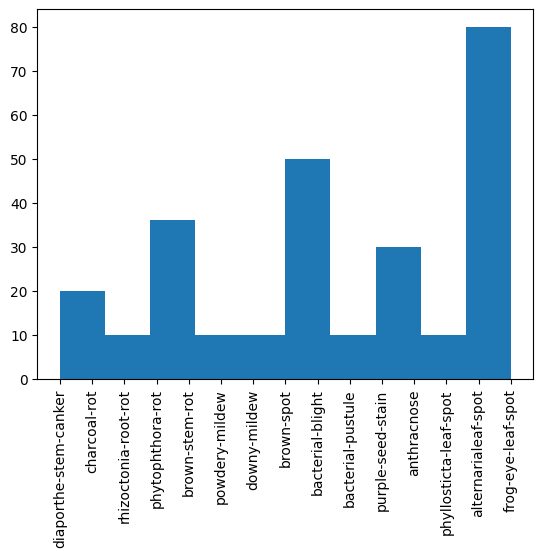

In [ ]:
plt.hist(df['class'])
plt.xticks(rotation=90)

Есть дисбаланс классов. Необходима балансировка.

Разделение на Х и у:

In [ ]:
X = df.drop(columns=['class', 'target'])
y = df['target']

# Балансировка классов с помощью SMOTE

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
y.value_counts()

target
7     40
6     40
14    40
11    40
5     40
12    40
8     40
4     40
2     40
3     40
13    40
1     40
10    40
0     40
9     40
Name: count, dtype: int64

Разбиение на трейн и тест:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size=0.75,
                                                    random_state=42)

# CatBoostClassifier

In [ ]:
cat_model = CatBoostClassifier(
   loss_function='MultiClass', verbose=False)

In [ ]:
cat_model.fit(X_train, y_train)

In [ ]:
cat_y_pred = cat_model.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, cat_y_pred)

# Print the precision and recall scores
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: [0.76923077 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.83333333
 1.         1.         1.        ]
Recall: [1.  0.8 1.  1.  1.  1.  1.  1.  1.  0.7 1.  1.  1.  1.  1. ]
F1-score: [0.86956522 0.88888889 1.         1.         1.         1.
 1.         1.         1.         0.82352941 1.         0.90909091
 1.         1.         1.        ]


In [ ]:
accuracy_score(y_test, cat_y_pred)

0.9666666666666667

# RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(random_state = 42)

rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, rf_y_pred)

# Print the precision and recall scores
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: [0.76923077 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
Recall: [1.  1.  1.  1.  1.  1.  1.  1.  1.  0.7 1.  1.  1.  1.  1. ]
F1-score: [0.86956522 1.         1.         1.         1.         1.
 1.         1.         1.         0.82352941 1.         1.
 1.         1.         1.        ]


In [ ]:
accuracy_score(y_test, rf_y_pred)

0.98

# GaussianNB

In [ ]:
nb_model = GaussianNB()

nb_model.fit(X_train, y_train)
nb_y_pred = nb_model.predict(X_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, nb_y_pred)

# Print the precision and recall scores
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: [0.58823529 1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.83333333 1.
 1.         1.         1.        ]
Recall: [1.  1.  1.  1.  0.4 1.  1.  1.  1.  0.7 1.  1.  1.  1.  1. ]
F1-score: [0.74074074 1.         1.         1.         0.57142857 1.
 1.         1.         1.         0.82352941 0.90909091 1.
 1.         1.         1.        ]


In [ ]:
accuracy_score(y_test, nb_y_pred)

0.94

# Построение кривых обучения для сравнения двух лучших моделей из трех: CatBoostClassifier и RandomForestClassifier

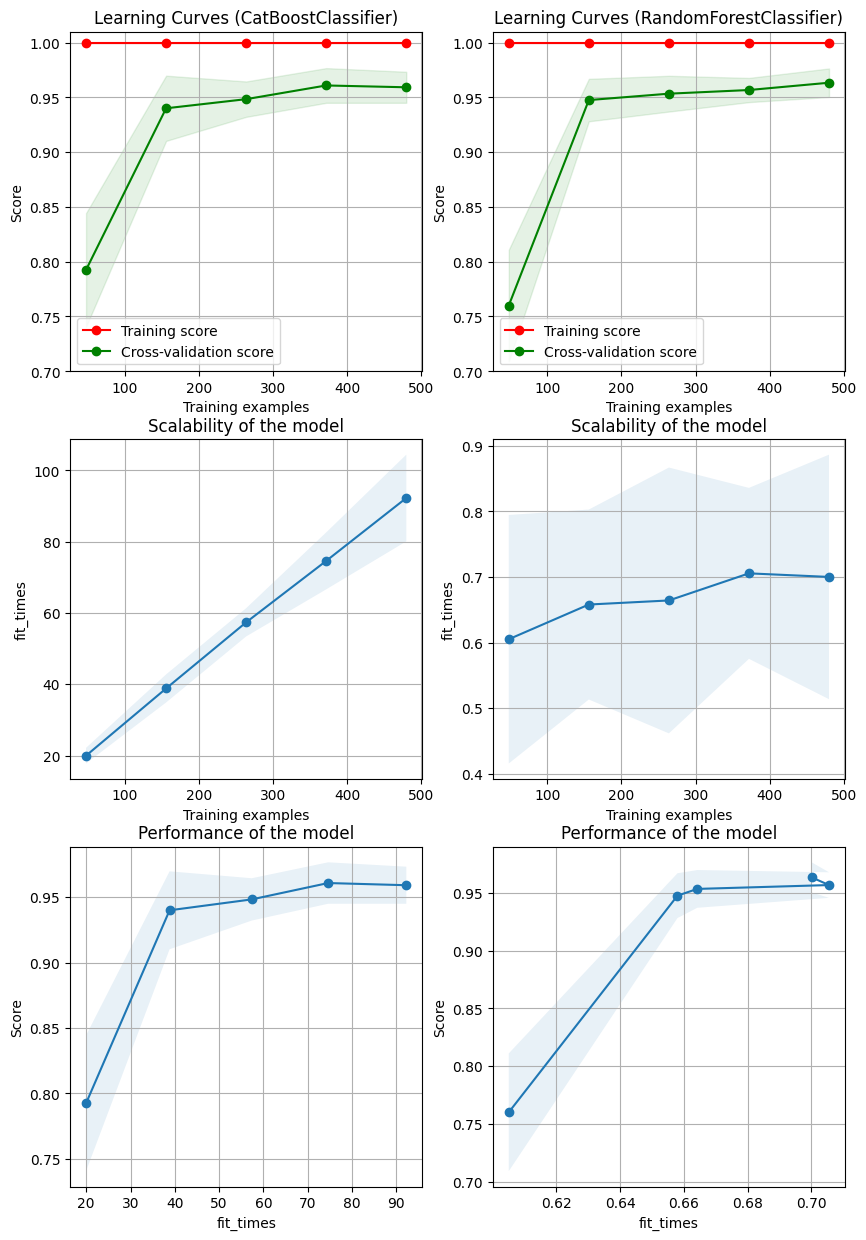

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (CatBoostClassifier)"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = cat_model
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (RandomForestClassifier)"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = rf_model
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)


plt.show()

# Визуализация результатов работы моделей

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.001s...
[t-SNE] Computed neighbors for 600 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 1.636938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.807018
[t-SNE] KL divergence after 1000 iterations: 0.271785


In [ ]:
cat_model.fit(X_tsne, y)

### CatBoostClassifier

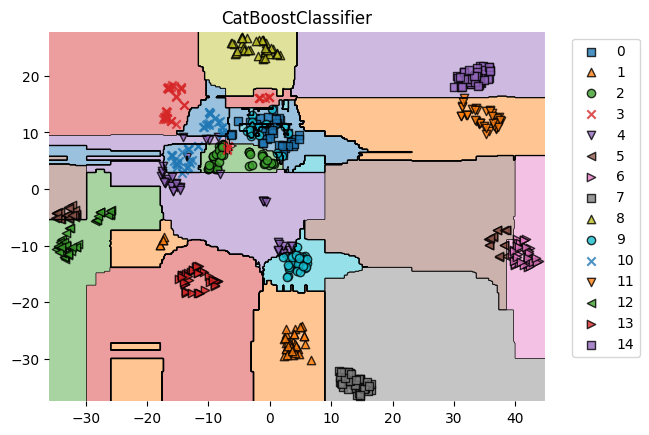

In [ ]:
cat_model.fit(X_tsne, y)
plot_decision_regions(X_tsne, np.array(y), clf=cat_model, legend=2)
plt.title('CatBoostClassifier')
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

### RandomForestClassifier

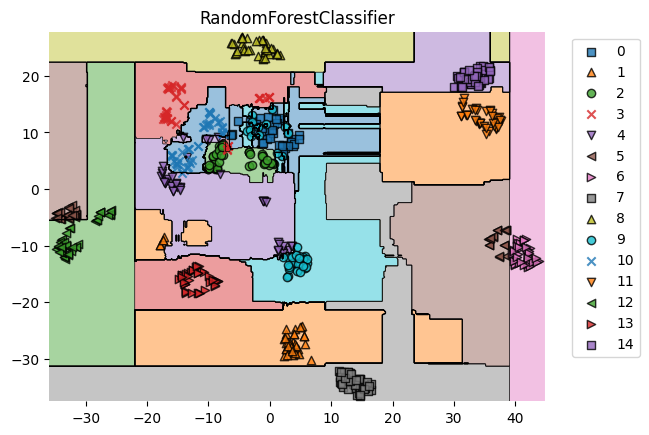

In [ ]:
rf_model.fit(X_tsne, y)
plot_decision_regions(X_tsne, np.array(y), clf=rf_model, legend=2)
plt.title('RandomForestClassifier')
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

### GaussianNB

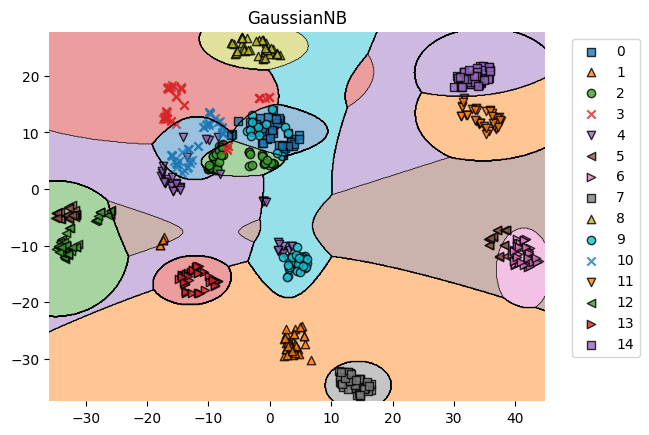

In [ ]:
nb_model.fit(X_tsne, y)
plot_decision_regions(X_tsne, np.array(y), clf=nb_model, legend=2)
plt.title('GaussianNB')
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
plt.show()

## Результаты моделей в 2D

In [ ]:
def graph_tsne(X, y):
  tsne = TSNE(n_components=2, verbose=1, random_state=123)
  X_tsne = tsne.fit_transform(X)
  print(f'Новая размерность Х: {X_tsne.shape}')
  print(f'Расхождение Кульбака-Лейблера после оптимизации: {tsne.kl_divergence_}')
  print(f'Сколько понадобилось итераций: {tsne.n_iter_}')
  graph = pd.DataFrame()
  graph['y'] = y
  graph['comp-1'] = X_tsne[:, 0]
  graph['comp-2'] = X_tsne[:, 1]
  sns.scatterplot(x='comp-1', y='comp-2', hue=graph.y.tolist(),
                  palette=sns.color_palette('hls', 15),
                  data=graph).set(title='Болезни соевых бобов через TSNE')
  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.001s...
[t-SNE] Computed neighbors for 150 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 2.399554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.102951
[t-SNE] KL divergence after 1000 iterations: 0.199521
Новая размерность Х: (150, 2)
Расхождение Кульбака-Лейблера после оптимизации: 0.19952130317687988
Сколько понадобилось итераций: 999


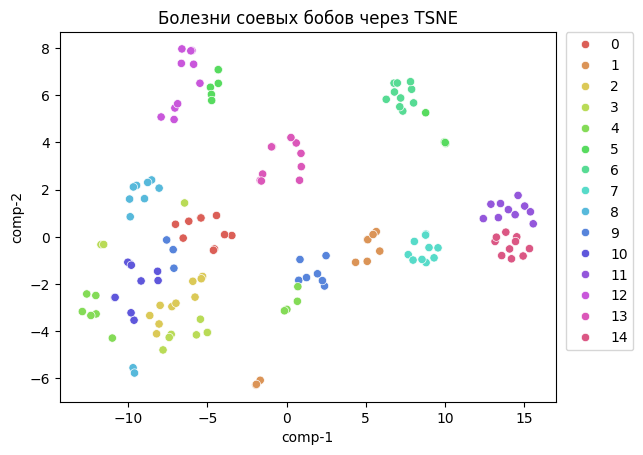

In [ ]:
graph_tsne(X_test, y_test)

### CatBoostClassifier

In [ ]:
cat_model.fit(X_train, y_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 2.399554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.102951
[t-SNE] KL divergence after 1000 iterations: 0.199521
Новая размерность Х: (150, 2)
Расхождение Кульбака-Лейблера после оптимизации: 0.19952130317687988
Сколько понадобилось итераций: 999


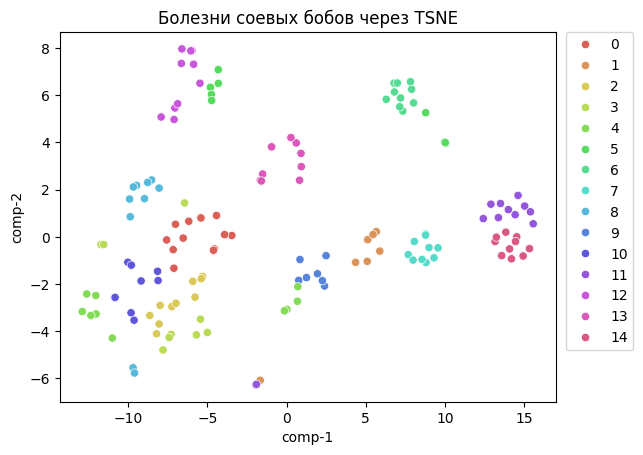

In [ ]:
graph_tsne(X_test, pd.DataFrame(cat_model.predict(X_test)))

### RandomForestClassifier

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 2.399554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.102951
[t-SNE] KL divergence after 1000 iterations: 0.199521
Новая размерность Х: (150, 2)
Расхождение Кульбака-Лейблера после оптимизации: 0.19952130317687988
Сколько понадобилось итераций: 999


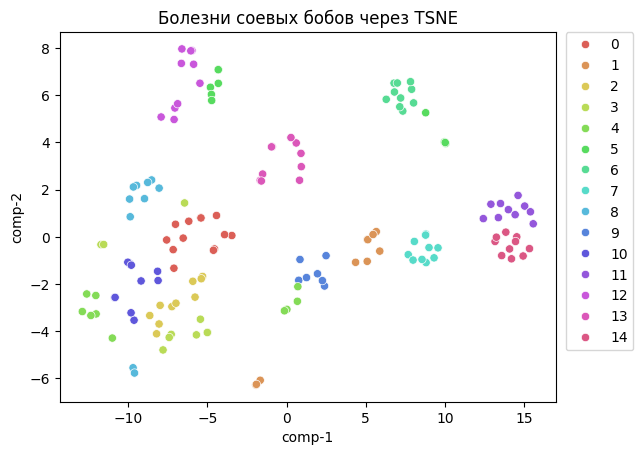

In [ ]:
graph_tsne(X_test, pd.DataFrame(rf_model.predict(X_test)))

### GaussianNB

In [ ]:
nb_model.fit(X_train, y_train)

GaussianNB()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.001s...
[t-SNE] Computed neighbors for 150 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 2.399554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.102951
[t-SNE] KL divergence after 1000 iterations: 0.199521
Новая размерность Х: (150, 2)
Расхождение Кульбака-Лейблера после оптимизации: 0.19952130317687988
Сколько понадобилось итераций: 999


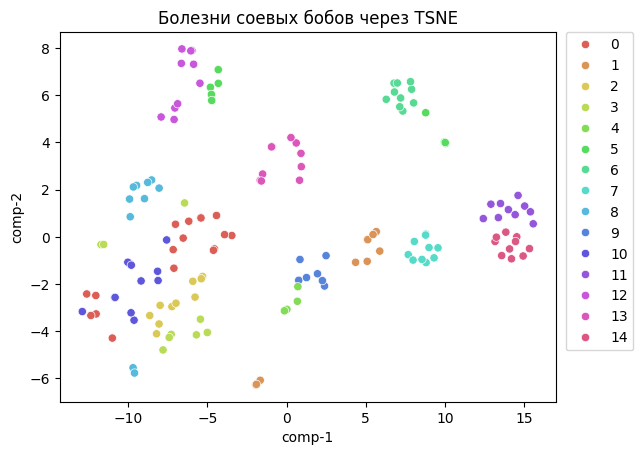

In [ ]:
graph_tsne(X_test, pd.DataFrame(nb_model.predict(X_test)))

### Библиотека umap

In [ ]:
def plot_2d_umap(X, y):
  umap_2d = UMAP(n_components=2, init='random', random_state=0)
  proj_2d = umap_2d.fit_transform(X)
  fig_2d = px.scatter(
      proj_2d, x=0, y=1,
      color=y, labels={'color':'болезни'}
  )
  fig_2d.show()

In [ ]:
plot_2d_umap(X_test, y_test)

#### CatBoostClassifier

In [ ]:
plot_2d_umap(X_test, np.array(cat_model.predict(X_test)).reshape(-1))

#### RandomForestClassifier

In [ ]:
plot_2d_umap(X_test, rf_model.predict(X_test))

#### GaussianNB

In [ ]:
plot_2d_umap(X_test, nb_model.predict(X_test))

Из трех моделелей самая точная - RandomForestClassifier. CatBoostClassifier - чуть хуже.

## Результаты моделей в 3D

In [ ]:
def plot_3d_umap(X, y):
  umap_3d = UMAP(n_components=3, init='random', random_state=0)
  proj_3d = umap_3d.fit_transform(X)
  fig_3d = px.scatter_3d(
      proj_3d, x=0, y=1, z=2,
      color=y, labels={'color':'болезни'}
  )
  fig_3d.update_traces(marker_size=5)
  fig_3d.show()

In [ ]:
plot_3d_umap(X_test, y_test)

### CatBoostClassifier

In [ ]:
plot_3d_umap(X_test, np.array(cat_model.predict(X_test)).reshape(-1))

### RandomForestClassifier

In [ ]:
plot_3d_umap(X_test, rf_model.predict(X_test))

### GaussianNB

In [ ]:
plot_3d_umap(X_test, nb_model.predict(X_test))

# Выводы

1. Из 19 классов могут быть предсказаны 15. Остальные не имеют смысловой нагрузки.
2. Модель RandomForestClassifier предсказывает все 15 классов с точностью и полнотой не менее 0.8.